Here, we modulate learning with the norm of A and B_late.

In [2]:
import nengo
import nengo_spa as spa
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

class Cycler():
    def __init__(
        self, 
        SPs, 
        relative_start,
        relative_stop,
        SP_duration,
        t_stop
    ):
        assert relative_start <= relative_stop
        self.SPs = SPs
        self.start = relative_start * SP_duration
        self.stop = relative_stop * SP_duration
        self.SP_duration = SP_duration
        self.t_stop = t_stop
        

    def make_step(self):
        def f(t):
            t_in_window = t % self.SP_duration
            idx = int((t % (self.SP_duration*len(self.SPs))) // self.SP_duration)
            if t_in_window>self.start and t_in_window<self.stop and t<self.t_stop:
                return self.SPs[idx]
            else:
                return "0"
        return f
    
n_SPs = 4
D = 32
subdimensions = 16
n_neurons = 50*subdimensions

vocab = spa.Vocabulary(D)
SPs = ['SP'+str(i) for i in range(n_SPs)]
vocab.populate(';'.join(SPs))

SP_vs = np.array([vocab.parse(SP).v for SP in SPs])
intercepts = [(np.dot(SP_vs[:,i*subdimensions:(i+1)*subdimensions], SP_vs[:,i*subdimensions:(i+1)*subdimensions].T) - np.eye(n_SPs)).flatten().max() for i in range(int(D/subdimensions))]
print(f"Intercepts: {intercepts}")



Intercepts: [0.07737900544697784, 0.17084535178773752]


In [4]:
with spa.Network() as model:
    
    n_training_cycles = 5
    T_learning = n_training_cycles * n_SPs

    A_f = Cycler(SPs, .25, .75, 1, n_SPs*999).make_step()
    A = spa.State(vocab, represent_cc_identity=False, subdimensions=subdimensions)
    A_inp = spa.Transcode(A_f, output_vocab=vocab)
    A_inp >> A

    B_f = Cycler(np.roll(SPs,-1), .5, 1, 1, n_SPs*n_training_cycles).make_step()
    B_predict = spa.State(vocab, represent_cc_identity=False, subdimensions=subdimensions)
    B_late = spa.Transcode(B_f, output_vocab=vocab)
    B_combined = spa.Transcode(input_vocab=vocab, output_vocab=vocab)
    B_predict >> B_combined
    B_late >> B_combined
    
    # Create the memory
    learning = nengo.Node(output=lambda t: -int(t >= n_training_cycles * n_SPs))
    memories = [
        nengo.Ensemble(n_neurons, subdimensions, intercepts=[intercepts[i]] * n_neurons)
        for i in range(int(D/subdimensions))
    ]
    
    # Learn the encoders/keys
    voja = nengo.Voja(learning_rate=5e-3, post_synapse=None)
    connections_in = [
        nengo.Connection(ens, memories[i], synapse=None, learning_rule_type=voja)
        for i,ens in enumerate(A.all_ensembles)
    ]
    for conn_in in connections_in:
        nengo.Connection(learning, conn_in.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    connections_out = [
        nengo.Connection(
            memories[i],
            B_predict.input[i*subdimensions:(i+1)*subdimensions],
            learning_rule_type=nengo.PES(1e-3),
            function=lambda x: np.zeros(subdimensions),
            synapse=None
        )
        for i in range(int(D/subdimensions))
    ]
    
    norms = nengo.Node(lambda t,x: np.linalg.norm(x[:D])*np.linalg.norm(x[D:]) > .5, size_in=2*D)
    nengo.Connection(A.output, norms[:D])
    nengo.Connection(B_late.output, norms[D:])

    # Create the error population
    errors = [nengo.Node(lambda t,x: x[:-1]*x[-1] if t<T_learning else 0, size_in=subdimensions+1) for i in range(int(D/subdimensions))]
    error_SP = spa.Transcode(input_vocab=vocab, output_vocab=vocab)
    for i in range(int(D/subdimensions)):
        nengo.Connection(errors[i], error_SP.input[i*subdimensions:(i+1)*subdimensions], synapse=None)
        nengo.Connection(norms, errors[i][-1], synapse=None)
        
    # Calculate the error and use it to drive the PES rule
    for i in range(int(D/subdimensions)):
        nengo.Connection(B_late.output[i*subdimensions:(i+1)*subdimensions], errors[i][:-1], transform=-1, synapse=None)
        nengo.Connection(B_predict.output[i*subdimensions:(i+1)*subdimensions], errors[i][:-1], synapse=None)
        nengo.Connection(errors[i], connections_out[i].learning_rule, synapse=None)
        
    
        
        
    # Setup probes
    p_A = nengo.Probe(A.output, synapse=.005)
    p_B_predict = nengo.Probe(B_predict.output, synapse=.005)
    p_B_late = nengo.Probe(B_late.output, synapse=.005)
    p_error = nengo.Probe(error_SP.output, synapse=0.005)
        

ValidationError: init: Shape of initial value () does not match expected shape (16, 32)

In [ ]:
T = T_learning * 2
with nengo.Simulator(model) as sim:
    sim.run(T)

In [7]:
def plot_similarities(
    t_range, data, vocab, title='', autoscale=False
):

    ymin, ymax = -1.2, 1.2
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis="y")
    plt.plot(t_range, spa.similarity(data, vocab))
    plt.title(title)
#     plt.xlabel("Time")
    plt.xlim(left=0, right=t_range[-1] * 3/4)
#     plt.legend(
#         list(vocab.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
#     )

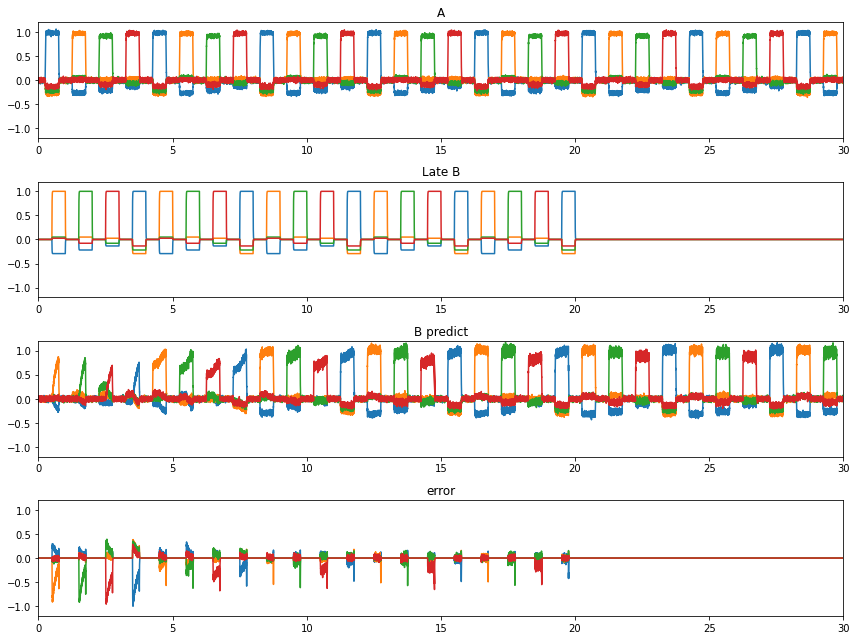

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(4, 1, 1)
plot_similarities(sim.trange(), sim.data[p_A], vocab, 'A')
plt.subplot(4, 1, 2)
plot_similarities(sim.trange(), sim.data[p_B_late], vocab, 'Late B')
plt.subplot(4, 1, 3)
plot_similarities(sim.trange(), sim.data[p_B_predict], vocab, 'B predict')
plt.subplot(4, 1, 4)
plot_similarities(sim.trange(), sim.data[p_error], vocab, 'error')

plt.tight_layout()
